In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 4 
EPOCHS = 50
DATA_DIR = "/kaggle/input/fairface/FairFace/train"
CSV_PATH = "/kaggle/input/fairface/FairFace/train_labels.csv"
SUBSET_SIZE = 86744
initial_learning_rate = 0.0001

nationality_dict = {
    0: ['White', 'Latino_Hispanic'],  # USA
    1: ['Indian'],                    # Indian
    2: ['Black'],                     # African
    3: ['Southeast Asian', 'Middle Eastern', 'East Asian']  # Other
}
df = pd.read_csv(CSV_PATH)
print(f"CSV loaded with {len(df)} rows")
print(f"Sample CSV rows:\n{df.head()}")

2025-08-02 07:35:53.314527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754120153.609379      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754120153.681842      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CSV loaded with 86744 rows
Sample CSV rows:
          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True


In [2]:
def map_race_to_nationality(race):
    for nat_id, races in nationality_dict.items():
        if race in races:
            return nat_id
    return None 

In [3]:
df['nationality'] = df['race'].apply(map_race_to_nationality)
df = df.dropna(subset=['nationality'])
print(f"Filtered CSV with {len(df)} rows after mapping nationalities")

nationalities = df['nationality'].unique()
print(f"Found nationalities in CSV: {nationalities}")
print(f"Sample files in {DATA_DIR}: {os.listdir(DATA_DIR)[:5]}")
df['file'] = df['file'].apply(os.path.basename)
print(f"Sample file paths after fixing:\n{df['file'].head()}")

Filtered CSV with 86744 rows after mapping nationalities
Found nationalities in CSV: [3 1 2 0]
Sample files in /kaggle/input/fairface/FairFace/train: ['64601.jpg', '31973.jpg', '30778.jpg', '19812.jpg', '22735.jpg']
Sample file paths after fixing:
0    1.jpg
1    2.jpg
2    3.jpg
3    4.jpg
4    5.jpg
Name: file, dtype: object


In [ ]:
#If Subset of dataset is chosen
if len(df) > SUBSET_SIZE:
    df = df.sample(n=SUBSET_SIZE, random_state=42, weights=df.groupby('nationality')['nationality'].transform('count'))
    print(f"Sampled CSV with {len(df)} rows")
else:
    print(f"Using all {len(df)} available images (less than SUBSET_SIZE={SUBSET_SIZE})")

df['nationality'] = df['nationality'].astype(str)

# Split into training, validation, and test sets
print("Splitting data into train, validation, and test sets")
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['nationality']
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['nationality']
)

print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")
print(f"Test set size: {len(test_df)} images")
print("Class distribution in training set:")
print(train_df['nationality'].value_counts())

#Computing class weights for imbalance
labels = train_df['nationality'].astype(int)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")


Using all 86744 available images (less than SUBSET_SIZE=86744)
Splitting data into train, validation, and test sets...
Training set size: 55516 images
Validation set size: 13879 images
Test set size: 17349 images
Class distribution in training set:
nationality
3    20670
0    19132
1     7884
2     7830
Name: count, dtype: int64
Class weights: {0: 0.7254338281413338, 1: 1.7604008117706749, 2: 1.7725415070242656, 3: 0.6714562167392356}


In [5]:
#Creating ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],  
    rotation_range=10            
) 
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Setting up generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=DATA_DIR,
    x_col='file',
    y_col='nationality',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=DATA_DIR,
    x_col='file',
    y_col='nationality',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=DATA_DIR,
    x_col='file',
    y_col='nationality',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 55516 validated image filenames belonging to 4 classes.
Found 13879 validated image filenames belonging to 4 classes.
Found 17349 validated image filenames belonging to 4 classes.


In [6]:
def build_model():
    model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754120427.973624      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754120427.974282      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,826,436 (18.41 MB)

 Trainable params: 4,822,084 (18.39 MB)

 Non-trainable params: 4,352 (17.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1754120441.166031     105 service.cc:148] XLA service 0x7bc57c00abb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754120441.167108     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754120441.167130     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754120442.243307     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754120472.350712     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.2926 - loss: 18.9284
Epoch 1: val_accuracy improved from -inf to 0.35344, saving model to /kaggle/working/nationalitytask5.weights.h5
867/867 ━━━━━━━━━━━━━━━━━━━━ 782s 855ms/step - accuracy: 0.2926 - loss: 18.9259 - val_accuracy: 0.3534 - val_loss: 12.6283 - learning_rate: 1.0000e-04
Epoch 2/50
  1/867 ━━━━━━━━━━━━━━━━━━━━ 3:47 263ms/step - accuracy: 0.4375 - loss: 12.4097

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.35344
867/867 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4375 - loss: 12.4097 - val_accuracy: 0.3515 - val_loss: 12.6213 - learning_rate: 1.0000e-04
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.3260 - loss: 10.9188
Epoch 3: val_accuracy did not improve from 0.35344
867/867 ━━━━━━━━━━━━━━━━━━━━ 343s 395ms/step - accuracy: 0.3260 - loss: 10.9170 - val_accuracy: 0.2986 - val_loss: 6.7460 - learning_rate: 1.0000e-04
Epoch 4/50
  1/867 ━━━━━━━━━━━━━━━━━━━━ 3:43 258ms/step - accuracy: 0.3125 - loss: 6.9829
Epoch 4: val_accuracy did not improve from 0.35344
867/867 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.3125 - loss: 6.9829 - val_accuracy: 0.3176 - val_loss: 6.6994 - learning_rate: 1.0000e-04
Epoch 5/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.3938 - loss: 5.8687
Epoch 5: val_accuracy improved from 0.35344 to 0.49834, saving model to /kaggle/working/nationalitytask5.weights.h5
867/867 ━━━━━━━━━

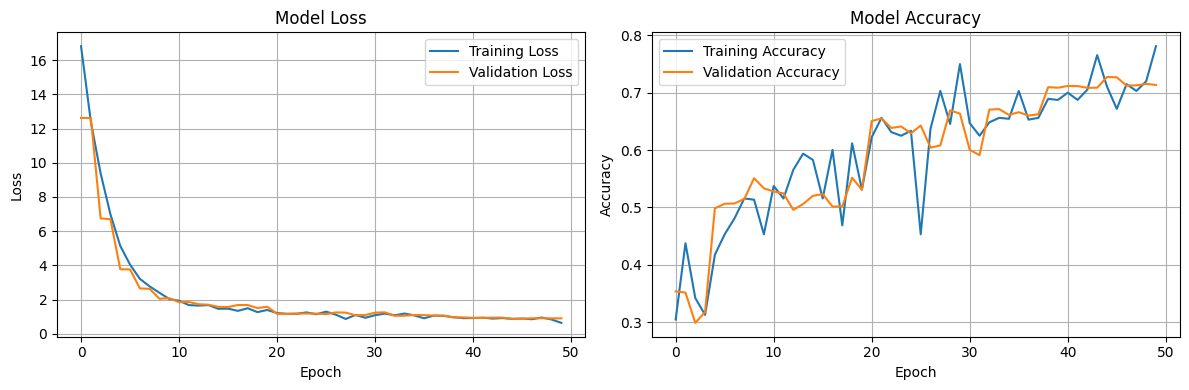


Final Training Accuracy: 0.7812
Final Validation Accuracy: 0.7135
Final Training Loss: 0.6324
Final Validation Loss: 0.8972
271/271 ━━━━━━━━━━━━━━━━━━━━ 128s 472ms/step - accuracy: 0.7234 - loss: 0.8703

Test Accuracy: 0.7238
Test Loss: 0.8675
Test Precision: 0.7285
Test Recall: 0.7238
Test F1 Score: 0.7233


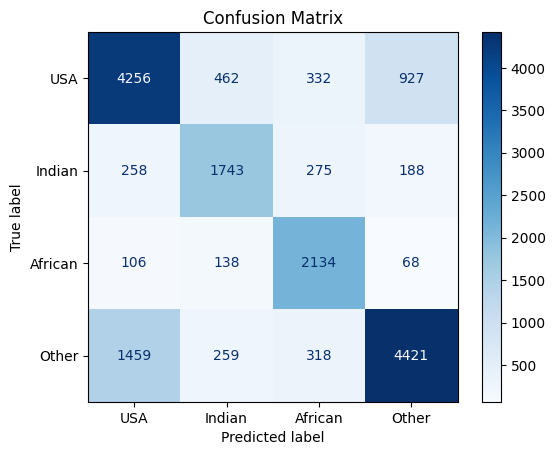

In [ ]:
#Calculating steps per epoch, validation and test steps
steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)
validation_steps = max(1, len(val_df) // BATCH_SIZE)
test_steps = max(1, len(test_df) // BATCH_SIZE)

model = build_model()

checkpoint = ModelCheckpoint(
    '/kaggle/working/nationalitytask5.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

print("Loading best weights.")
model.load_weights("/kaggle/working/nationalitytask5.weights.h5")


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps, verbose=1)

test_generator.reset() 
y_true = []
y_pred = []
for i in range(test_steps):
    try:
        batch_x, batch_y = next(test_generator)
        y_true.extend(np.argmax(batch_y, axis=1))
        y_pred.extend(np.argmax(model.predict(batch_x, verbose=0), axis=1))
    except StopIteration:
        break
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
class_labels = ["USA", "Indian", "African", "Other"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

model.save("/kaggle/working/nationalitytask5.h5")